In [60]:
import numpy as np
import matplotlib.pyplot as plt
from data import load_training_data, load_test_data, split_data
import networkx as nx
import time, datetime
from utils import plot_graph
from tqdm import tqdm

from n_walk import product_graph, graph_product, graph_product_el, get_labels_nodes
import kernel_class as kc
import kernel_methods as km

from importlib import reload

In [2]:
graphs, labels =  load_training_data()
submi_graphs = load_test_data()

# Test of graph product

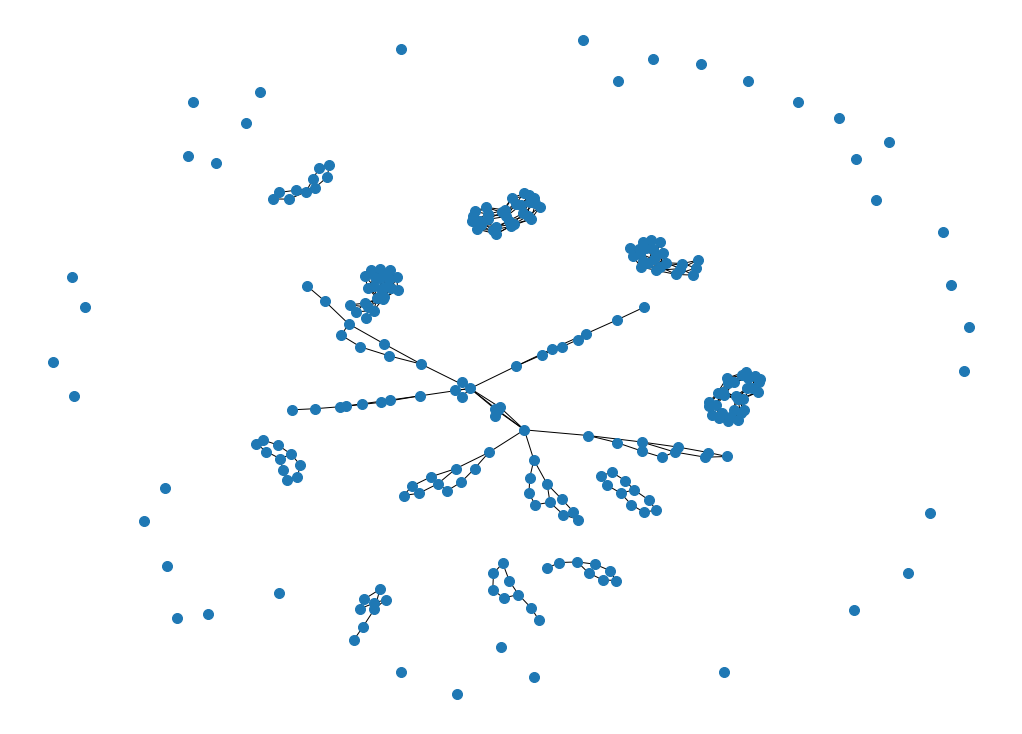

In [3]:
g1, g2 = graphs[:2]
plt.figure(figsize=(14, 10))
gp = product_graph(g1, g2)
nx.draw(gp, node_size = 100)

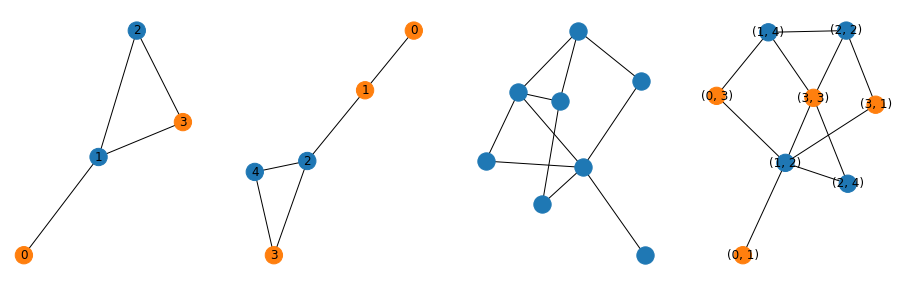

In [13]:
ga = nx.Graph([(0, 1), (1, 2), (1, 3), (2, 3)])
for v, l in zip(range(4), [0, 1, 1, 0]) : ga.nodes[v]["labels"] = [l]
gb = nx.Graph([(0, 1), (1, 2), (2, 3), (3, 4), (4, 2)])
for v, l in zip(range(5), [0, 0, 1, 0, 1]) : gb.nodes[v]["labels"] = [l]

plt.figure(figsize=(20, 5))
plt.subplot(1, 5, 1)
plot_graph(ga)
plt.subplot(1, 5, 2)
plot_graph(gb)
plt.subplot(1, 5, 3)
gp = product_graph(ga, gb)
initial_nodes = dict(gp.nodes)
for v in initial_nodes:
    if len(gp.edges(v))==0:
        gp.remove_node(v)
nx.draw(gp)
plt.subplot(1, 5, 4)
plot_graph(graph_product(ga, gb, with_lonely_nodes=False))

# Test product graph speed

In [14]:
np.random.seed(42)
g1_indices = np.random.choice(len(graphs), 6000, replace=True)
g2_indices = np.random.choice(len(graphs), 6000, replace=True)

def convert_time(seconds_tot):
    seconds = int(seconds_tot%60)
    minutes_tot = int(seconds_tot//60)
    if minutes_tot == 0: return f"{seconds}s"
    minutes = minutes_tot%60
    hours = int(minutes_tot//60)
    if hours == 0: return f"{minutes}m {seconds}s"
    return f"{hours}h {minutes}m {seconds}s"


def test_speed_one_graph(f, *args, **kwargs):
    n_in, n_out = 100, 60
    times_list = []
    for i in range(n_out):
        t0 = time.time()
        for j in range(n_in):
            g = graphs[g1_indices[i*n_in + j]]
            f(g, *args, **kwargs)
        t1 = time.time()
        times_list.append(t1 - t0)
    times_full = np.array(times_list)/n_in * (6000*6001)/2 #time to compute the whole gram matrix
    print(convert_time(times_full.mean()), ", ", convert_time(times_full.std()))
    return times_full

def test_speed_two_graphs(f, *args, **kwargs):
    n_in, n_out = 100, 60
    times_list = []
    for i in range(n_out):
        t0 = time.time()
        for j in range(n_in):
            g1 = graphs[g1_indices[i*n_in + j]]
            g2 = graphs[g2_indices[i*n_in + j]]
            f(g1, g2, *args, **kwargs)
        t1 = time.time()
        times_list.append(t1 - t0)
    times_full = np.array(times_list)/n_in * (6000*6001)/2 #time to compute the whole gram matrix
    print(convert_time(times_full.mean()), ", ", convert_time(times_full.std()))
    return times_full

In [20]:
from n_walk import product_graph, graph_product, graph_product_el
d = test_speed_two_graphs(product_graph)

19h 53m 43s ,  4h 4m 1s


In [21]:
d = test_speed_two_graphs(graph_product)

7h 57m 43s ,  2h 39m 12s


In [22]:
d = test_speed_two_graphs(graph_product, with_lonely_nodes=False)

5h 53m 40s ,  59m 27s


In [23]:
d = test_speed_two_graphs(graph_product_el)

8h 9m 12s ,  2h 54m 24s


In [24]:
d = test_speed_two_graphs(graph_product_el, with_lonely_nodes=False)

4h 41m 6s ,  1h 14m 44s


# Test of Random Walk Kernel and its acceleration.

In [318]:
sub_graphs, sub_labels = split_data(n_splits=3)[0]
souby = sub_graphs[:20]

100%|██████████| 20/20 [00:00<00:00, 21.90it/s]


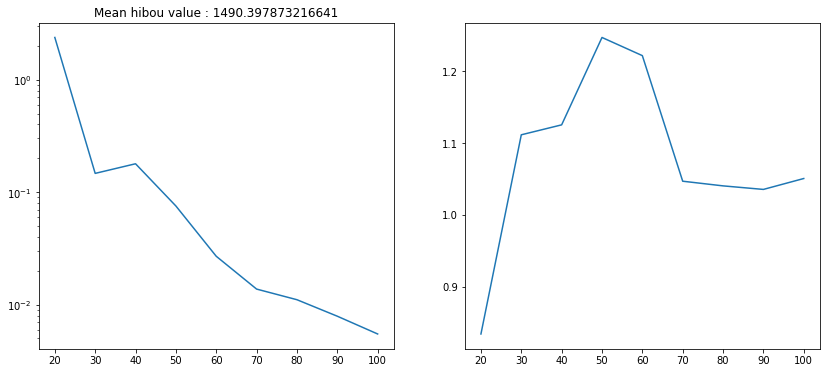

In [341]:
reload(kc)
# chouette = kc.RandomWalkKernelNaive(0.95, norm1=True, norm2=True, exclude_lonely_nodes=False)
hibou    = kc.RandomWalkKernel(0.95, norm1=True, norm2=False, exclude_intruding_nodes=True, exclude_lonely_nodes=False, fast=False)
hibou_souby = hibou.compute_gram_matrix(souby)

exec_times = []
accur = []
max_iters = range(20, 110, 10)
for max_iter in max_iters:
    aigle    = kc.RandomWalkKernel(0.95, norm1=True, norm2=False, exclude_intruding_nodes=True, exclude_lonely_nodes=False, fast=True, max_iter=max_iter)
    t0 = time.time()
    aigle_souby = aigle.compute_gram_matrix(souby)
    t1 = time.time()
    exec_times.append(t1-t0)
    accur.append(np.max(np.abs(aigle_souby - hibou_souby)))
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(max_iters, accur)
plt.title(f"Mean hibou value : {np.abs(hibou_souby).mean()}")
plt.yscale('log')
plt.subplot(122)
plt.plot(max_iters, exec_times)


100%|██████████| 20/20 [00:03<00:00,  6.39it/s]


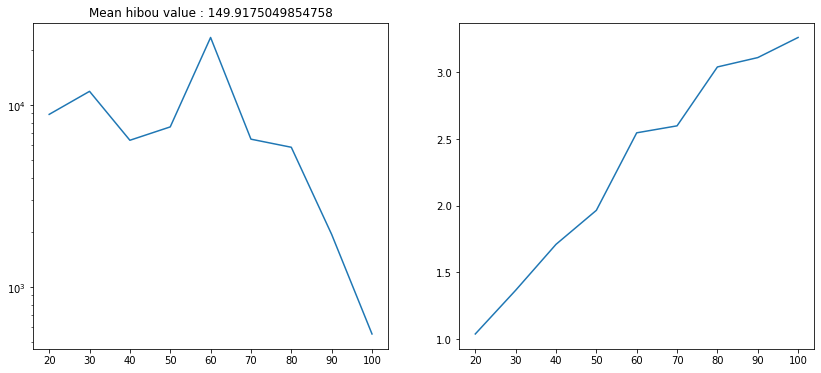

In [343]:
reload(kc)
# chouette = kc.RandomWalkKernelNaive(0.95, norm1=True, norm2=True, exclude_lonely_nodes=False)
hibou    = kc.RandomWalkKernel(0.95, norm1=False, norm2=False, exclude_intruding_nodes=True, exclude_lonely_nodes=False, fast=False)
hibou_souby = hibou.compute_gram_matrix(souby)

exec_times = []
accur = []
max_iters = range(20, 110, 10)
for max_iter in max_iters:
    aigle    = kc.RandomWalkKernel(0.95, norm1=False, norm2=False, exclude_intruding_nodes=True, exclude_lonely_nodes=False, fast=True, max_iter=max_iter)
    t0 = time.time()
    aigle_souby = aigle.compute_gram_matrix(souby)
    t1 = time.time()
    exec_times.append(t1-t0)
    accur.append(np.max(np.abs(aigle_souby - hibou_souby)))
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(max_iters, accur)
plt.title(f"Mean hibou value : {np.abs(hibou_souby).mean()}")
plt.yscale('log')
plt.subplot(122)
plt.plot(max_iters, exec_times)

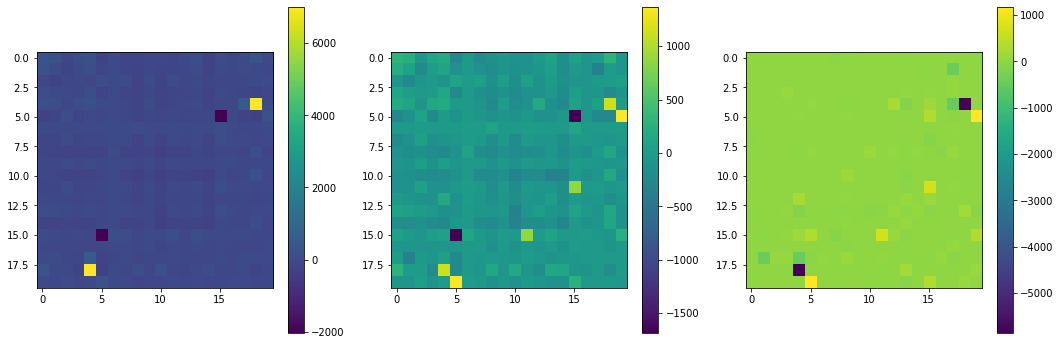

In [335]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.imshow(hibou_souby)
plt.colorbar()
plt.subplot(132)
plt.imshow(aigle_souby)
plt.colorbar()
plt.subplot(133)
plt.imshow(aigle_souby - hibou_souby)
plt.colorbar()

# With grakel

In [228]:
from grakel import RandomWalkLabeled, RandomWalk
rwgk = RandomWalkLabeled(lamda=0.95, method_type='fast')
gs = [nx.adjacency_matrix(g).toarray() for g in sub_graphs[:2]]
nls = [[x[0] for x in nx.get_node_attributes(g, "labels").values()] for g in sub_graphs[:2]]
rwgk.fit_transform(zip(gs, nls))

# Computing kernels

In [6]:
split_list, split_idx = split_data(n_splits=3, return_indices=True)
submi_graphs = load_test_data()

sub_graphs, sub_labels = split_list[1]
sub_idx = split_idx[1]
upper_submi = submi_graphs[:1000]

In [4]:
print(split_idx[0])
print(split_idx[1])
print(split_idx[2])

[   0    2    6 ... 5987 5993 5999]
[   3    5    9 ... 5989 5990 5994]
[   1    4    8 ... 5996 5997 5998]


In [9]:
random_walk_kernel = kc.RandomWalkKernel(lam=0.95, save_kernel=True) #norm1=True, norm2=False, exclude_intruding_nodes=True, exclude_lonely_nodes=False, fast=True, max_iter=100

In [10]:
# my_outer_gram = random_walk_kernel.compute_outer_gram(upper_submi, sub_graphs, save_suf="3_subsets_1submi_upper")
# now_str = datetime.datetime.now().strftime("%m%d_%H%M%S%f")
# np.save(f"saved/RandomWalkKernel_outer_3_subsets_1submi_{now_str}_idx_submi.npy", upper_submi)
# np.save(f"saved/RandomWalkKernel_outer_3_subsets_1submi_{now_str}_idx_train.npy", sub_graphs)

100%|██████████| 1000/1000 [1:45:05<00:00,  6.31s/it] 


In [13]:
np.bincount(np.random.binomial(n=1, p=0.9, size=100)*2-1)

ValueError: 'list' argument must have no negative elements

In [29]:
# from multiprocessing import Pool

# blocs = [
#     (submi_graphs[:10], sub_graphs[:10]),
#     (submi_graphs[:10], sub_graphs[10:20]),
#     (submi_graphs[10:20], sub_graphs[:10]),
#     (submi_graphs[10:20], sub_graphs[10:20])
# ]

# personal_rwk = [kc.RandomWalkKernel(lam = 0.95, save_kernel=True) for i_bloc in range(4)]

# malettes = [t for t in zip(blocs, personal_rwk, np.arange(4))]

# def par_func(malette):
#     submi_list, train_list = malette[0]
#     rwk_perso = malette[1]
#     i_bloc = malette[2]
#     res = rwk_perso.compute_outer_gram(submi_list, train_list)
#     suf = datetime.datetime.now().strftime("%m%d%_h%m%s")
#     # np.save(f'saved/RWK_{suf}_{i_bloc}_idx_submi.npy', submi_list)
#     # np.save(f'saved/RWK_{suf}_{i_bloc}_idx_train.npy', train_list)
#     return res

# with Pool(4) as p:
#     res_svg = p.map(par_func, malettes)

# Kernels correction

In [181]:
split_list, split_idx = split_data(n_splits=3, return_indices=True)
submi_graphs = load_test_data()

sub_graphs, sub_labels = split_list[1]
sub_idx = split_idx[1]

K = np.load("saved/RandomWalkKernel_outer_3_subsets_1submi.npy")

In [182]:
def correct_kernel(K, slow_kernel, sub_graphs1, sub_graphs2 = None, tol=0.01, stop_cond=10):
    n = K.shape[0]
    K_correct = np.copy(K)
    inner = sub_graphs2 is None
    if inner: sub_graphs2 = sub_graphs1
    assert K.shape[0] == len(sub_graphs1)
    assert K.shape[1] == len(sub_graphs2)

    idx_big = np.argsort(np.abs(K).flatten(order='C'))[::-1]
    # nan are at the beginning
    i_big = idx_big//n
    j_big = idx_big%n

    if inner:
        # To remove the lower triangular part
        of_interest = j_big >= i_big
        i_big = i_big[of_interest]
        j_big = j_big[of_interest]
    
    k_old_list = []
    k_cor_list = []
    k_diff_list = []
    is_tol_list = []
    for q in range(len(i_big)):
        i, j = i_big[q], j_big[q]
        k_cor, info = slow_kernel.kernel_eval(sub_graphs1[i], sub_graphs2[j])
        k_old = K[i, j]
        k_diff = k_cor - k_old
        is_tol = not(np.isnan(k_old)) and (np.abs(k_diff) < tol*np.abs(k_old))

        if q%100 == 0 or is_tol: 
            print(f"{q}: {k_cor} {k_old} {k_diff}              ", end="\r")

        k_old_list.append(k_old)
        k_cor_list.append(k_cor)
        k_diff_list.append(k_diff)
        is_tol_list.append(is_tol)

        # if is_tol:
        #     cntn = input(f"{q} {k_cor} {k_old} {k_diff}")
        #     if cntn=="stop":
        #         break
        
        K_correct[i, j] = k_cor
        if inner:
            K_correct[j, i] = k_cor
        
        if np.all(is_tol_list[-stop_cond:]): 
            break

    return K_correct, k_old_list, k_cor_list, k_diff_list

In [183]:
rwk_slow = kc.RandomWalkKernel(lam=0.95, fast=False)
processed_graphs = [rwk_slow.filter_graph(g) for g in sub_graphs]

In [168]:
processed_submi_graphs = [rwk_slow.filter_graph(g) for g in submi_graphs]

In [184]:
K_correct, k_old_list, k_cor_list, k_diff_list = correct_kernel(K, rwk_slow, processed_submi_graphs, processed_graphs)

In [186]:
# np.save("saved/RandomWalkKernel_outer_3_subsets_1submi_corrected.npy", K_correct)

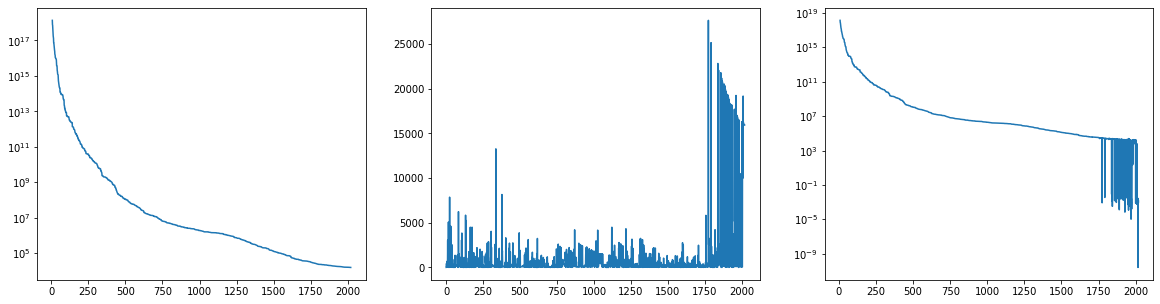

In [185]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(np.abs(k_old_list))
plt.yscale('log')
plt.subplot(132)
plt.plot(k_cor_list)
plt.subplot(133)
plt.plot(np.abs(k_diff_list))
plt.yscale('log')

In [222]:
def psdwarp(K):
    w, v = np.linalg.eigh(K)
    w_pos_part = np.maximum(0, w)
    K_psd = (v*w_pos_part)@v.T
    return K_psd

In [223]:
for i in range(3):
    K = np.load(f"saved/RandomWalkKernel_3_subset_{i}.npy")
    print(np.min(np.linalg.eigvalsh(K)))
    K_psd = psdwarp(K)
    print(np.min(np.linalg.eigvalsh(K_psd)))
    np.save(f"saved/RandomWalkKernel_3_subset_{i}_psd.npy", psdwarp(K))

-148401.01630173906
-8.676396167115319e-11
-89895.52598855199
-1.2853785893170987e-10
-45311.8022718523
-7.021333841029193e-11


# Kernel analysis

In [187]:
split_list, split_idx = split_data(n_splits=3, return_indices=True)
submi_graphs = load_test_data()

sub_graphs, sub_labels = split_list[0]
sub_idx = split_idx[0]

K = np.load("saved/RandomWalkKernel_3_subset_0.npy")

In [203]:
K_diag = K[np.arange(len(K)), np.arange(len(K))]
K_ind = np.sqrt(K_diag[:,None]*K_diag[None,:])

c:\Users\leobu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


In [198]:
for i in range(1, 2000):
    ev = np.linalg.eigvalsh(K[:i,:i])
    if ev.min() < 0:
        break
i

36

In [209]:
np.count_nonzero(np.abs(K[:i,:i]) > K_ind[:i,:i])

0

In [213]:
w, v = np.linalg.eigh(K)
w_pos_part = np.maximum(0, w)
K_psd = (v*w_pos_part)@v.T

In [221]:
np.count_nonzero(np.abs(K_psd - K) > 0.1*np.abs(K))
np.linalg.eigvalsh(K_psd).min()

-8.676396167115319e-11

# Bin

In [3]:
from itertools import product as iter_product
from scipy.sparse.linalg import cg, LinearOperator

def my_filter_graph( g, norm1=True):
    """Process a graph to objects needed in kernel computations

    Args:
        g (nx.Graph): graph to process

    Returns:
        tuple(dict, ndarray of dim 1): First element is filt_adj, a dictionnary whose keys are all the possible pairs of labels of g
            and values are adjacency matrices masked with edges corresponding to those pairs. Second element is g_labels, the array
            of the labels of the nodes of g (same length as g).
    """
    g_labels = np.array(get_labels_nodes(g))
    A = nx.adjacency_matrix(g).toarray()
    if norm1:
        degrees = np.sum(A, axis=1, keepdims=True)
        A = A/np.where(degrees == 0, 1, degrees) # Markov transition matrix
    filt_adj = {}
    for (l1, l2) in iter_product(g_labels, g_labels):
        A_l1_l2 = (g_labels == l1)[:,None] * A * (g_labels == l2)[None, :] # entries of A corresponding to an edge between a node labeled l1 and a node labeled l2
        filt_adj[(l1, l2)] = A_l1_l2
    return filt_adj, g_labels

def my_kernel_eval(g1, g2, lam, fast=True, exclude_lonely_nodes = False, exclude_intruding_nodes=True, norm2=False, max_iter=100):
    """Computes the Rangom walk kernel value of g1 and g2. Warning ! They must be processed

    Args:
        processed_g1 (tuple(dict, ndarray)): object return by filter_graph
        processed_g2 (tuple(dict, ndarray)): object return by filter_graph
    """
    processed_g1, processed_g2 = my_filter_graph(g1), my_filter_graph(g2)
    fa1, gl1 = processed_g1 # filtered adjacency matrix, graph labels
    fa2, gl2 = processed_g2

    common_labels = set(fa1.keys()) & set(fa2.keys())
    len_prod = len(gl1)*len(gl2)

    if not fast:
        A_prod = np.zeros((len_prod, len_prod))
        for lalb in common_labels:
            A_prod += np.kron(fa1[lalb], fa2[lalb])
        # A_prod is now the adj matrix of the product graph (with intruding nodes)

        degrees = np.sum(A_prod, axis=1)
        nb_lonely_nodes = np.count_nonzero(degrees == 0) # we will add this quantity at the end
        A_prod = A_prod[np.ix_(degrees !=0, degrees!=0)]

        if exclude_lonely_nodes:
            nb_lonely_nodes = 0
        elif exclude_intruding_nodes:
            intruding_nodes = gl1[:,None] != gl2[None,:]
            nb_lonely_nodes -= np.count_nonzero(intruding_nodes)
        
        ImA_inv = np.linalg.inv(np.eye(A_prod.shape[0]) - lam * A_prod)
        k_res = np.sum(ImA_inv) + nb_lonely_nodes

        if norm2:
            k_res /= (A_prod.shape[0] + nb_lonely_nodes)
        return k_res

    else: # Fast method
        #The computation for this method is inpired by Vishwanathan 2008, and Grakel implementation.

        A_subs = [(fa1[lalb], fa2[lalb]) for lalb in common_labels]
        
        if exclude_intruding_nodes:
            intruding_nodes = gl1[:,None] != gl2[None,:]
            nb_intruding_nodes = np.count_nonzero(intruding_nodes)
        else:
            nb_intruding_nodes = 0
        print(nb_intruding_nodes)
        
        def lin_op(r):
            # inspired from grakel, but with few corrections
            # print(r)
            wR = np.zeros((len(gl1), len(gl2)))
            R = np.reshape(r, (len(gl1), len(gl2)), order='C')
            for A_sub1, A_sub2 in A_subs:
                wR += np.linalg.multi_dot((A_sub1, R, A_sub2.T)) #could be done faster with sparse matrices ?
            return r - lam * wR.flatten(order='C')
        
        print(len_prod)
        LO = LinearOperator((len_prod, len_prod), matvec=lin_op)
        sol, _ = cg(LO, np.ones(len_prod), tol=1e-6, maxiter=max_iter, atol='legacy')
        
        A_prod = np.zeros((len_prod, len_prod)) # To delete
        for lalb in common_labels:
            A_prod += np.kron(fa1[lalb], fa2[lalb])
        M = np.eye(A_prod.shape[0]) - lam * A_prod
        return M, lin_op
        # print(np.max(np.abs(1 - lin_op(sol))), np.max(np.abs(1 - M@sol)), np.max(np.abs(sol)))

        k_res =  np.sum(sol) - nb_intruding_nodes
        if norm2:
            k_res /= (len_prod - nb_intruding_nodes)
        return k_res

In [4]:
print(np.count_nonzero(np.isnan(K)))
print(np.count_nonzero(K > 1e3))
print(np.count_nonzero(K > 1e4))
print(np.count_nonzero(K > 1e5))
print(np.count_nonzero(K > 1e6))
print(np.count_nonzero(K > 1e7))
print(np.count_nonzero(K > 1e8))
print(np.count_nonzero(K > 1e9))
print(np.count_nonzero(K > 1e10))
print(np.count_nonzero(K > 1e11))
print(np.count_nonzero(K > 1e12))
print(np.count_nonzero(K > 1e13))
print(np.count_nonzero(K > 1e14))
print(np.count_nonzero(K > 1e15))
print(np.count_nonzero(K > 1e16))
print(np.count_nonzero(K > 1e17))
print(np.count_nonzero(K > 1e18))
print(np.count_nonzero(K > 1e19))

12
699591
2932
766
464
300
198
162
148
104
82
64
52
38
20
4
2
0


In [5]:
np.nonzero(np.isnan(K))

(array([ 177,  643,  643,  643,  669,  972,  972,  972, 1352, 1531, 1532,
        1539], dtype=int64),
 array([ 972,  669, 1352, 1539,  643,  177, 1531, 1532,  643,  972,  972,
         643], dtype=int64))

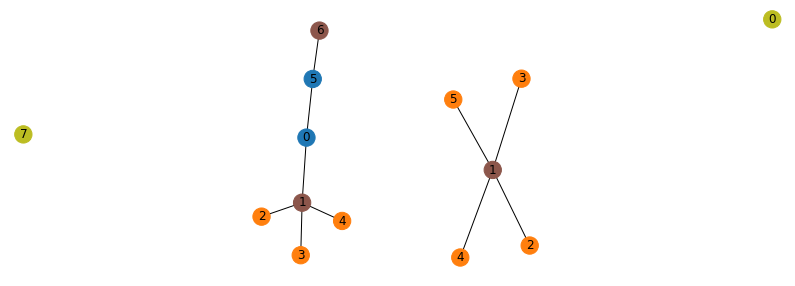

In [6]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plot_graph(sub_graphs[177])
plt.subplot(122)
plot_graph(sub_graphs[972])

In [59]:
reload(kc)
rwk = kc.RandomWalkKernel(0.95, fast=True)
# rwk.kernel_eval_unprocessed(sub_graphs[177], sub_graphs[972])
ktest = rwk.compute_gram_matrix(sub_graphs[:200]);

100%|██████████| 200/200 [01:44<00:00,  1.91it/s]


In [62]:
print(np.count_nonzero(rwk.errors))
mask_errors = rwk.errors !=0
print(np.median(ktest[mask_errors]))
print(np.median(ktest[~mask_errors]))

# plt.hist(ktest[~mask_errors], range=[-2e4, 2e4], bins=50, density=True)
# plt.hist(ktest[mask_errors] , range=[-2e4, 2e4], bins=50, density=True, alpha=0.7, rwidth=0.8);

447
501.50517443475746
980.8877820584191


In [66]:
processed_graphs = np.array([rwk.filter_graph(g) for g in sub_graphs[:200]])

rwk_slow = kc.RandomWalkKernel(0.95, fast=False)
k_slow = []
for i, j in tqdm(zip(*np.nonzero(rwk.errors))):
    k_res, info = rwk_slow.kernel_eval(processed_graphs[i], processed_graphs[j])
    k_slow.append(k_res)
    if info != 0:
        print(i,j,info, k_res)

447it [00:06, 67.27it/s] 


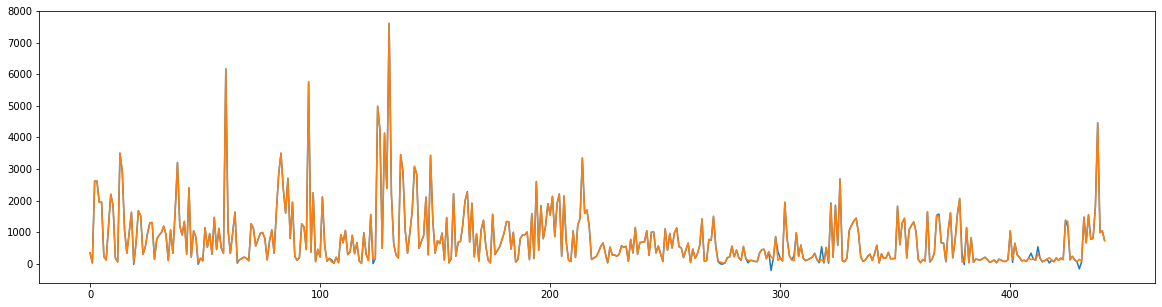

In [100]:
error_indices = np.nonzero(rwk.errors)
k_slow = np.array(k_slow)
k_fast = ktest[error_indices]
idx = np.abs(k_fast) < 1e4
plt.figure(figsize=(20, 5))
plt.plot(k_fast[idx])
plt.plot(k_slow[idx])

In [110]:
M, lin_op = my_kernel_eval(sub_graphs[177], sub_graphs[972], 0.95, fast=True)

33
48


In [111]:
my_sol = np.linalg.inv(M).sum(axis=1)
my_psol = my_sol
print(my_psol)
lin_op(my_psol), M.dot(my_psol)

[1.         1.         1.         1.         1.         1.
 1.         5.29980658 1.         1.         1.         1.
 1.         1.         6.03481625 6.03481625 6.03481625 6.03481625
 1.         1.         6.03481625 6.03481625 6.03481625 6.03481625
 1.         1.         6.03481625 6.03481625 6.03481625 6.03481625
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]


(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

In [113]:
L0 = LinearOperator((48, 48), matvec=lin_op)
cg(L0, np.ones(48), tol=1e-6, maxiter=100, atol='legacy')

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan]), 100)